# Transpiler Passes and Pass Manager

## Introduction

A central component of Qiskit Terra is the transpiler, which is designed for modularity and extensibility. The goal is to be able to easily write new circuit transformations (known as transpiler **passes**), and combine them with other existing passes.  Which passes are chained together and in which order has a major effect on the final outcome. This pipeline is determined by a **pass manager**, which schedules the passes and also allows passes to communicate with each other by providing a shared space. In this way, the transpiler opens up the door for research into aggressive optimization of quantum circuits.

In this notebook, we look at the built-in passes, how to use the pass manager, and develop a simple custom transpiler pass. In order to do the latter, we first need to introduce the internal representation of quantum circuits in Qiskit, in the form of a Directed Acyclic Graph, or **DAG**. Then, we illustrate a simple swap mapper pass, which transforms an input circuit to be compatible with a limited-connectivity quantum device.

***Before you start***: You may need to install the `pydot` library and the `graphviz` library for the DAG plotting routines. If you are using Anaconda Python, you can install both with the `conda` command. If you use your system's native Python interpreter, install `pydot` using the `pip` command, and install `graphviz` using your system's native package manager (e.g. `yum`, `apt`, `dnf`, `brew`, etc.).

In [1]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

## PassManager object

Lets you specify the set of passes you want.

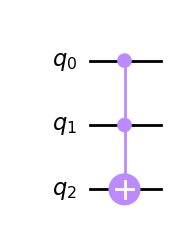

In [2]:
circ = QuantumCircuit(3)
circ.ccx(0, 1, 2)
circ.draw(output='mpl')

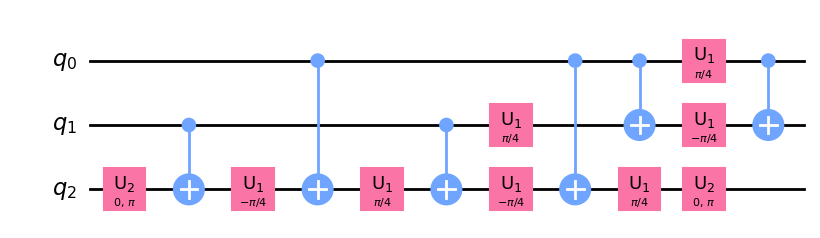

In [3]:
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(circ)
new_circ.draw(output='mpl')

All of Qiskit's transpiler passes are accessible from ``qiskit.transpiler.passes``.

In [4]:
from qiskit.transpiler import passes
[pass_ for pass_ in dir(passes) if pass_[0].isupper()]

['ALAPSchedule',
 'ALAPScheduleAnalysis',
 'ASAPSchedule',
 'ASAPScheduleAnalysis',
 'AlignMeasures',
 'ApplyLayout',
 'BIPMapping',
 'BarrierBeforeFinalMeasurements',
 'BasicSwap',
 'BasisTranslator',
 'CSPLayout',
 'CXCancellation',
 'CXDirection',
 'CheckCXDirection',
 'CheckGateDirection',
 'CheckMap',
 'Collect1qRuns',
 'Collect2qBlocks',
 'CollectCliffords',
 'CollectLinearFunctions',
 'CollectMultiQBlocks',
 'CommutationAnalysis',
 'CommutativeCancellation',
 'CommutativeInverseCancellation',
 'Commuting2qGateRouter',
 'ConsolidateBlocks',
 'ConstrainedReschedule',
 'ContainsInstruction',
 'ConvertConditionsToIfOps',
 'CountOps',
 'CountOpsLongestPath',
 'CrosstalkAdaptiveSchedule',
 'DAGFixedPoint',
 'DAGLongestPath',
 'Decompose',
 'DenseLayout',
 'Depth',
 'DynamicalDecoupling',
 'EchoRZXWeylDecomposition',
 'EnlargeWithAncilla',
 'Error',
 'FixedPoint',
 'FullAncillaAllocation',
 'GateDirection',
 'GatesInBasis',
 'HighLevelSynthesis',
 'HoareOptimizer',
 'InstructionDuratio

## Different Variants of the Same Pass

There can be passes that do the same job, but in different ways. For example, the ``TrivialLayout``, ``DenseLayout`` and ``NoiseAdaptiveLayout`` all choose a layout (binding of virtual qubits to physical qubits), but use different algorithms and objectives. Similarly, the ``BasicSwap``, ``LookaheadSwap`` and ``StochasticSwap`` all insert swaps to make the circuit compatible with the coupling map. The modularity of the transpiler allows plug-and-play replacements for each pass.

Below, we show the swapper passes all applied to the same circuit, to transform it to match a linear chain topology. You can see differences in performance, where the ``StochasticSwap`` is clearly the best. However, this can vary depending on the input circuit.

In [5]:
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap

coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]

circuit = QuantumCircuit(7)
circuit.h(3)
circuit.cx(0, 6)
circuit.cx(6, 0)
circuit.cx(0, 1)
circuit.cx(3, 1)
circuit.cx(3, 0)

coupling_map = CouplingMap(couplinglist=coupling)

bs = BasicSwap(coupling_map=coupling_map)
pass_manager = PassManager(bs)
basic_circ = pass_manager.run(circuit)

ls = LookaheadSwap(coupling_map=coupling_map)
pass_manager = PassManager(ls)
lookahead_circ = pass_manager.run(circuit)

ss = StochasticSwap(coupling_map=coupling_map)
pass_manager = PassManager(ss)
stochastic_circ = pass_manager.run(circuit)

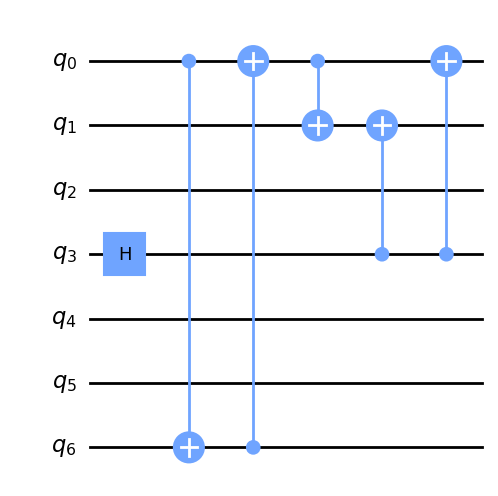

In [6]:
circuit.draw(output='mpl')

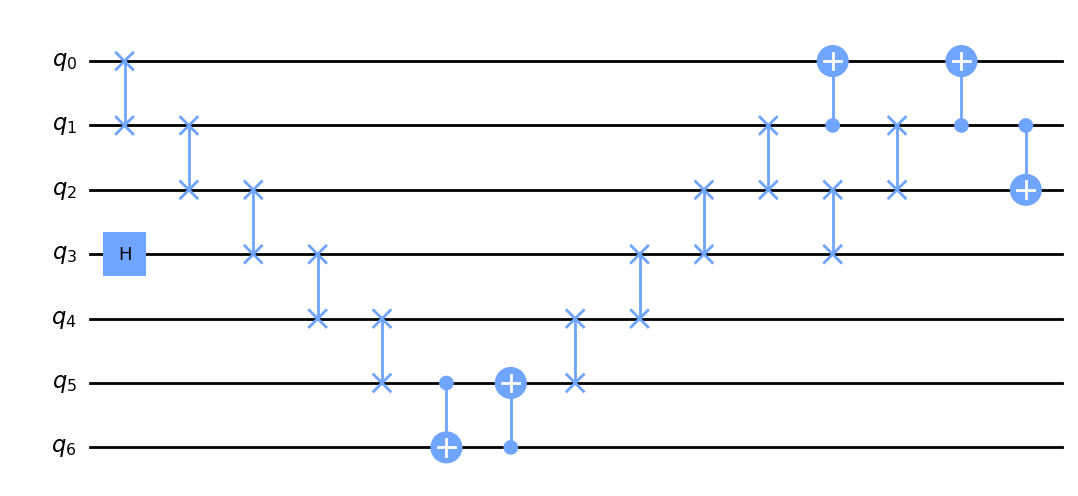

In [7]:
basic_circ.draw(output='mpl')

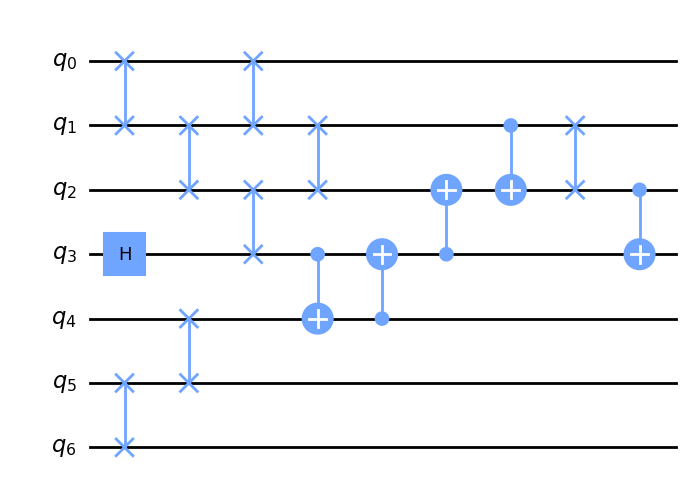

In [8]:
lookahead_circ.draw(output='mpl')

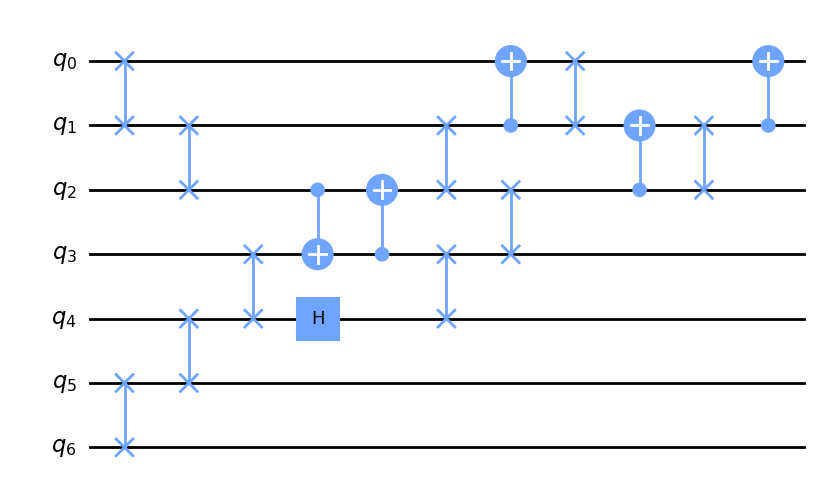

In [9]:
stochastic_circ.draw(output='mpl')

## Preset Pass Managers

Qiskit comes with several pre-defined pass managers, corresponding to various levels of optimization achieved through different pipelines of passes. Currently ``optimization_level`` 0 through 3 are supported; the higher the number, the more optimized it is, at the expense of more time. Choosing a good pass manager may take trial and error, as it depends heavily on the circuit being transpiled and the backend being targeted.

Here we illustrate the different levels by looking at a state synthesis circuit. We initialize four qubits to an arbitrary state, and then try to optimize the circuit that achieves this.

- ``optimization_level=0``: just maps the circuit to the backend, with no explicit optimization (except whatever optimizations the mapper does).

- ``optimization_level=1``: maps the circuit, but also does light-weight optimizations by collapsing adjacent gates.

- ``optimization_level=2``: medium-weight optimization, including a noise-adaptive layout and a gate-cancellation procedure based on gate commutation relationships.

- ``optimization_level=3``: heavy-weight optimization, which in addition to previous steps, does resynthesis of two-qubit blocks of gates in the circuit.

In [10]:
import math
from qiskit.providers.fake_provider import FakeTokyo

backend = FakeTokyo()     # mimics the tokyo device in terms of coupling map and basis gates

In [11]:
qc = QuantumCircuit(10)

random_state = [
    1 / math.sqrt(4) * complex(0, 1),
    1 / math.sqrt(8) * complex(1, 0),
    0,
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(8) * complex(1, 0),
    1 / math.sqrt(8) * complex(0, 1),
    0,
    0,
    0,
    0,
    1 / math.sqrt(4) * complex(1, 0),
    1 / math.sqrt(8) * complex(1, 0)]

qc.initialize(random_state, range(4))
qc.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
q_9: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                           ├
«     │                                                                            │
«q_1: ┤1                                                                           ├
«     │  Initialize(0.5j,0.35355,0,0,0,0,0,0,0.35355,0.35355j,0,0,0,0,0.5,0.35355) │
«q_2: ┤2                                                                           ├
«     │                                                                            │
«q_3: ┤3                                                                           ├
«     └────────────────────────────────────────────────────────────────────────────┘
«q_4: ──────────────────────────────────────────────────────────────────────────────
«                                                                                   
«q_5: ──────────────────────────────────────────────────────────────────────────────
«                                                                                   
«q_6: ──────────────────────────────────────────────────────────────────────────────
«                                                                                   
«q_7: ──────────────────────────────────────────────────────────────────────────────
«                                                                                   
«q_8: ──────────────────────────────────────────────────────────────────────────────
«                                                                                   
«q_9: ──────────────────────────────────────────────────────────────────────────────
«

Now map this to the 20-qubit Tokyo device, with different optimization levels:

In [12]:
optimized_0 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=0)
print('gates = ', optimized_0.count_ops())
print('depth = ', optimized_0.depth())

gates =  OrderedDict([('cx', 70), ('u3', 15), ('u1', 14), ('reset', 4)])
depth =  86


In [13]:
optimized_1 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=1)
print('gates = ', optimized_1.count_ops())
print('depth = ', optimized_1.depth())

gates =  OrderedDict([('cx', 22), ('u3', 15), ('u1', 6), ('reset', 4)])
depth =  41


In [14]:
optimized_2 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=2)
print('gates = ', optimized_2.count_ops())
print('depth = ', optimized_2.depth())

gates =  OrderedDict([('cx', 20), ('u3', 15), ('u1', 6), ('reset', 4)])
depth =  39


In [15]:
optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

gates =  OrderedDict([('cx', 20), ('u3', 15), ('u1', 6), ('reset', 4)])
depth =  39


## Introducing the DAG

In Qiskit, we represent circuits internally using a Directed Acyclic Graph (DAG). The advantage of this representation over a pure list of gates (i.e., *netlist*) is that the flow of information between operations are explicit, making it easier for passes to make transformation decisions without changing the semantics of the circuit.

Let's start by building a simple circuit, and examining its DAG.

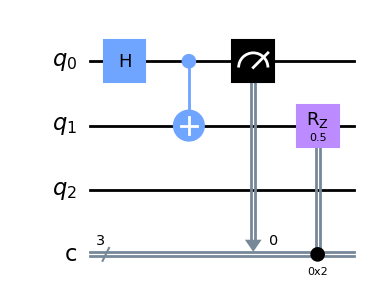

In [16]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
circ = QuantumCircuit(q, c)
circ.h(q[0])
circ.cx(q[0], q[1])
circ.measure(q[0], c[0])
circ.rz(0.5, q[1]).c_if(c, 2)
circ.draw(output='mpl')

In the DAG, there are three kinds of graph nodes: qubit/clbit input nodes (green), operation nodes (blue), and output nodes (red). Each edge indicates data flow (or dependency) between two nodes. 

ValueError: Could not save to JPEG for display

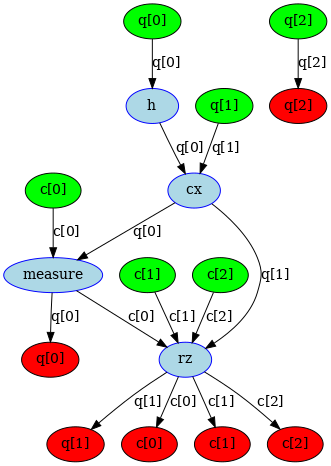

In [17]:
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
dag = circuit_to_dag(circ)
dag_drawer(dag)

Therefore, writing a transpiler pass means using Qiskit's DAGCircuit API to analyze or transform the circuit. Let's see some examples of this.

**a. Get all op nodes in the DAG:**

In [18]:
dag.op_nodes()

[DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=()),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)), cargs=()),
 DAGOpNode(op=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qargs=(Qubit(QuantumRegister(3, 'q'), 0),), cargs=(Clbit(ClassicalRegister(3, 'c'), 0),)),
 DAGOpNode(op=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.5]), qargs=(Qubit(QuantumRegister(3, 'q'), 1),), cargs=())]

Each node is an instance of the ``DAGOpNode`` class. Let's examine the information stored in the fourth op node.

In [19]:
node = dag.op_nodes()[3]
print("node name: ", node.name)
print("node op: ", node.op)
print("node qargs: ", node.qargs)
print("node cargs: ", node.cargs)
print("node condition: ", node.op.condition)

node name:  rz
node op:  Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.5])
node qargs:  (Qubit(QuantumRegister(3, 'q'), 1),)
node cargs:  ()
node condition:  (ClassicalRegister(3, 'c'), 2)


**b. Add an operation to the back:**

ValueError: Could not save to JPEG for display

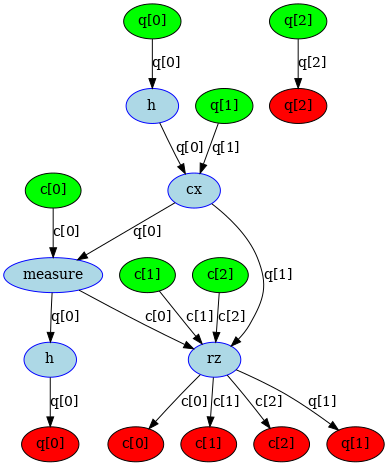

In [20]:
from qiskit.circuit.library import HGate
dag.apply_operation_back(HGate(), qargs=[q[0]])
dag_drawer(dag)

**c. Add an operation to the front:**

ValueError: Could not save to JPEG for display

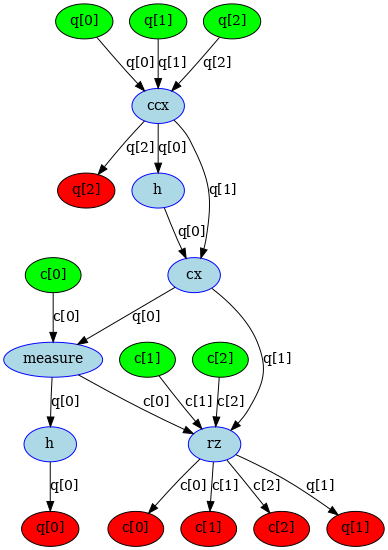

In [21]:
from qiskit.circuit.library import CCXGate
dag.apply_operation_front(CCXGate(), qargs=[q[0], q[1], q[2]], cargs=[])
dag_drawer(dag)

**d. Substitute a node with a subcircuit:**

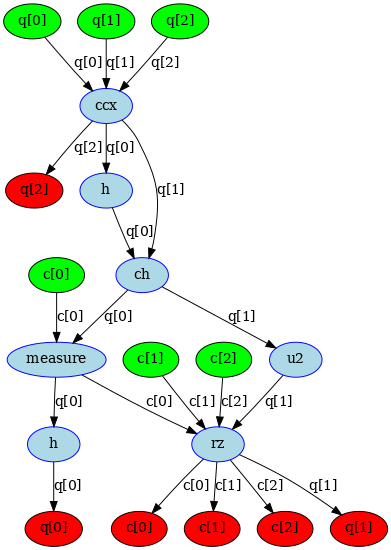

In [22]:
from qiskit.circuit.library import CHGate, U2Gate, CXGate
mini_dag = DAGCircuit()
p = QuantumRegister(2, "p")
mini_dag.add_qreg(p)
mini_dag.apply_operation_back(CHGate(), qargs=[p[1], p[0]])
mini_dag.apply_operation_back(U2Gate(0.1, 0.2), qargs=[p[1]])

# substitute the cx node with the above mini-dag
cx_node = dag.op_nodes(op=CXGate).pop()
dag.substitute_node_with_dag(node=cx_node, input_dag=mini_dag, wires=[p[0], p[1]])
dag_drawer(dag)

Finally, after all transformations are complete, we can convert back to a regular QuantumCircuit object.
This is what the transpiler does! It takes a circuit, operates on it in DAG form, and outputs a transformed circuit.

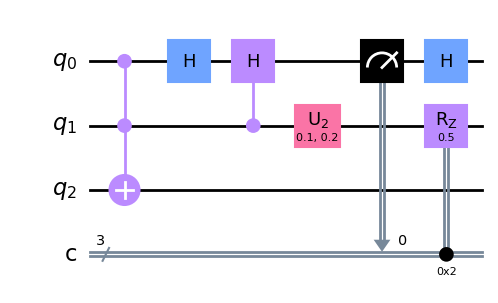

In [23]:
from qiskit.converters import dag_to_circuit
circuit = dag_to_circuit(dag)
circuit.draw(output='mpl')

## Implementing a BasicMapper Pass

Now that we are familiar with the DAG, let's use it to write a transpiler pass. Here we will implement a basic pass for mapping an arbitrary circuit to a device with limited qubit connectivity. We call this the BasicMapper. This pass is included in Qiskit Terra as well.

The first thing to do when writing a transpiler pass is to decide whether the pass class derives from a ``TransformationPass`` or ``AnalysisPass``. Transformation passes modify the circuit, while analysis passes only collect information about a circuit (to be used by other passes). Then, the ``run(dag)`` method is implemented, which does the main task. Finally, the pass is registered inside the ``qiskit.transpiler.passes`` module.

This pass functions as follows: it traverses the DAG layer-by-layer (each layer is a group of operations acting on independent qubits, so in theory all operations in a layer can be done independently). For each operation, if it does not already meet the coupling map constraints, the pass identifies a swap path and inserts swaps to bring the two qubits close to each other.

Follow the comments in the code for more details.

In [24]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate


class BasicSwap(TransformationPass):
    """Maps (with minimum effort) a DAGCircuit onto a `coupling_map` adding swap gates."""

    def __init__(self,
                 coupling_map,
                 initial_layout=None):
        """Maps a DAGCircuit onto a `coupling_map` using swap gates.
        
        Args:
            coupling_map (CouplingMap): Directed graph represented a coupling map.
            initial_layout (Layout): initial layout of qubits in mapping
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        """Runs the BasicSwap pass on `dag`.
        
        Args:
            dag (DAGCircuit): DAG to map.

        Returns:
            DAGCircuit: A mapped DAG.

        Raises:
            TranspilerError: if the coupling map or the layout are not
            compatible with the DAG.
        """
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)
        

        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())

        if len(dag.qubits) != len(self.initial_layout):
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError(
                "Mappers require to have the layout to be the same size as the coupling map")
            
        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
        current_layout = trivial_layout.copy()

        for layer in dag.serial_layers():
            subdag = layer['graph']

            for gate in subdag.two_qubit_ops():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if self.coupling_map.distance(physical_q0, physical_q1) != 1:
                    # Insert a new layer with the SWAP(s).
                    swap_layer = DAGCircuit()
                    swap_layer.add_qreg(canonical_register)

                    path = self.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        # create the swap operation
                        swap_layer.apply_operation_back(SwapGate(),
                                                        qargs=[qubit_1, qubit_2],
                                                        cargs=[])

                    # layer insertion
                    order = current_layout.reorder_bits(new_dag.qubits)
                    new_dag.compose(swap_layer, qubits=order)

                    # update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])

            order = current_layout.reorder_bits(new_dag.qubits)
            new_dag.compose(subdag, qubits=order)

        return new_dag

Let's test this pass on a small example circuit.

In [25]:
q = QuantumRegister(7, 'q')
in_circ = QuantumCircuit(q)
in_circ.h(q[0])
in_circ.cx(q[0], q[4])
in_circ.cx(q[2], q[3])
in_circ.cx(q[6], q[1])
in_circ.cx(q[5], q[0])
in_circ.rz(0.1, q[2])
in_circ.cx(q[5], q[0])

Now we construct a pass manager that contains our new pass. We pass the example circuit above to this pass manager, and obtain a new, transformed circuit.

In [26]:
from qiskit.transpiler import PassManager
from qiskit.transpiler import CouplingMap
from qiskit import BasicAer
pm = PassManager()
coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]
coupling_map = CouplingMap(couplinglist=coupling)

pm.append([BasicSwap(coupling_map)])

out_circ = pm.run(in_circ)

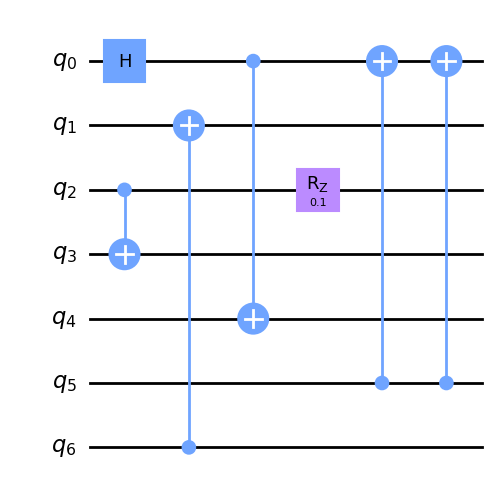

In [27]:
in_circ.draw(output='mpl')

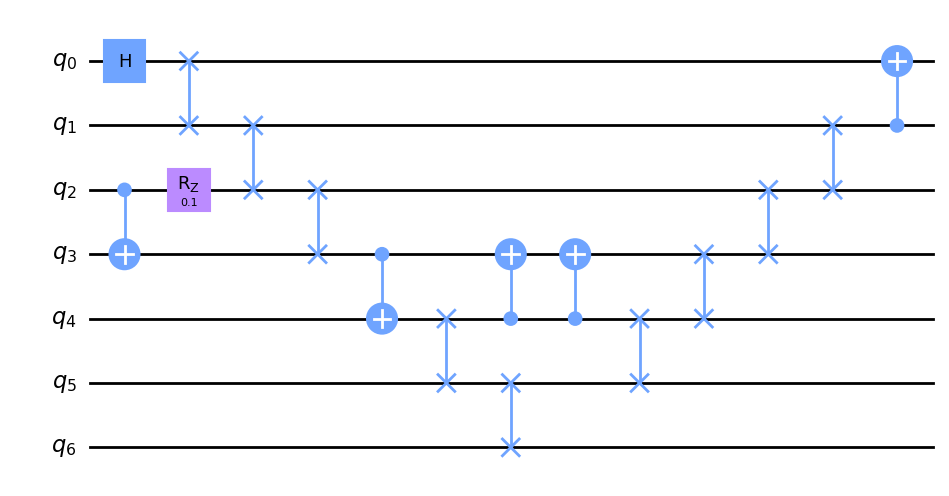

In [28]:
out_circ.draw(output='mpl')

Note that this pass only inserts the swaps necessary to make every two-qubit interaction conform to the device coupling map. It does not, for example, care about the direction of interactions, or the native gate set supported by the device. This is a design philosophy of Qiskit's transpiler: every pass performs a small, well-defined action, and the aggressive circuit optimization is achieved by the pass manager through combining multiple passes.

## Transpiler Logging <a name='logging'></a>

Due to the complexity of the internal operations that the transpiler is performing it's likely that you'll end up in a situation where you'd like to debug an issue or just understand more of what is happening inside the transpiler when you call it. To facilitate this the transpiler emits log messages as part of its normal operation. This logging uses the Python standard library `logging` module to emit the log messages. Python's standard logging was used because it allows Qiskit-Terra's logging to integrate in a standard way with other applications and libraries.

For a more thorough introduction to Python logging refer to the [official documentation](https://docs.python.org/3/library/logging.html) and the tutorials and cookbook linked off of there.

<div class="alert alert-block alert-success">
    <b>Note:</b> Most of the <code>logging</code> module functions used in this section adjust global settings. If you run commands in this section it might effect the output from other cells if they are run in a different order.
</div>

### Configuring Python Standard Library Logging

By default Python Standard Logging only prints log messages at the `WARNING`, `ERROR`, or `CRITICAL` log levels.
Since none of the logs emitted by the transpiler use these log levels (they're all informative) you need to configure logging.

The simplest way to do this is to just run:

In [29]:
import logging

logging.basicConfig(level='DEBUG')

The `basicConfig()` function (see the docs here: https://docs.python.org/3/library/logging.html#logging.basicConfig) configures a root handler and formatter. We also specify the [log level](https://docs.python.org/3/library/logging.html#levels) to display with the `level` kwarg. Setting it to a level will also include and higher levels. For example, if you set it to `'INFO'`, in addition to the `INFO` level, this will also include the `WARNING`, `ERROR`, and `CRITICAL` log levels.

Now the python environment in this notebook is configured to emit log messages to stderr when you run the transpiler. For example:

<div class="alert alert-block alert-success">
    <b>Note:</b> <code>basicConfig()</code> will only work when called the first time it's called. It detects if a root handler and formatter have already been setup (either by using an earlier <code>basicConfig()</code> call or otherwise) and does nothing if they have. Further adjustments will have to by interacting with the handler directly.
</div>

In [30]:
from qiskit.providers.fake_provider import FakeTenerife


log_circ = QuantumCircuit(2, 2)
log_circ.h(0)
log_circ.h(1)
log_circ.h(1)
log_circ.x(1)
log_circ.cx(0, 1)
log_circ.measure([0,1], [0,1])

backend = FakeTenerife()

transpile(log_circ, backend);

DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='noise_adaptive', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoiseAdaptiveLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='synthesis', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnitarySynthesisPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='translator', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasisTranslatorPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='unroller', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnrollerPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:OptimizationPassManager', group='qiskit.transpiler.optimization')


DEBUG:stevedore.extension:found extension EntryPoint(name='alap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AlapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='asap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AsapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='noise_adaptive', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoiseAdaptiveLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='synthesis', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnitarySynthesisPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='translator', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasisTranslatorPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='unroller', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnrollerPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:OptimizationPassManager', group='qiskit.transpiler.optimization')


DEBUG:stevedore.extension:found extension EntryPoint(name='alap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AlapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='asap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AsapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


INFO:qiskit.passmanager.passrunner:Pass: ContainsInstruction - 0.02527 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnitarySynthesis - 0.12302 (ms)


INFO:qiskit.passmanager.passrunner:Pass: HighLevelSynthesis - 0.05245 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Unroll3qOrMore - 0.02646 (ms)


INFO:qiskit.passmanager.passrunner:Pass: SetLayout - 0.01431 (ms)


INFO:qiskit.passmanager.passrunner:Pass: TrivialLayout - 0.07081 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckMap - 0.05507 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FullAncillaAllocation - 0.12159 (ms)


INFO:qiskit.passmanager.passrunner:Pass: EnlargeWithAncilla - 0.11563 (ms)


INFO:qiskit.passmanager.passrunner:Pass: ApplyLayout - 0.42582 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckMap - 0.04363 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnitarySynthesis - 0.11373 (ms)


INFO:qiskit.passmanager.passrunner:Pass: HighLevelSynthesis - 0.03862 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnrollCustomDefinitions - 0.41223 (ms)


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to target basis {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Begining basis search from {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate u generated using rule 
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate r generated using rule 
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate h generated using rule 
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate p generated using rule 
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate rx generated using rule 
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate x generated using rule 
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Transformation path:


DEBUG:qiskit.transpiler.passes.basis.basis_translator:x/1 => []
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:rx/1 => [Parameter(theta)]
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:p/1 => [Parameter(theta)]
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:h/1 => []
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:r/1 => [Parameter(theta), Parameter(phi)]
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:u/1 => [Parameter(theta), Parameter(phi), Parameter(lam)]
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.698s.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: x/1 [] =>
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updating transform for mapped instr ('x', 1) x, [] from 
     ┌───┐
q76: ┤ x ├
     └───┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updated transform for mapped instr ('x', 1) x, [] to
     ┌───────────┐
q76: ┤ U3(π,0,π) ├
     └───────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: rx/1 [Parameter(theta)] =>
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: p/1 [Parameter(theta)] =>
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: h/1 [] =>
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updating transform for mapped instr ('h', 1) h, [] from 
     ┌───┐
q73: ┤ h ├
     └───┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updated transform for mapped instr ('h', 1) h, [] to
     ┌─────────┐
q73: ┤ U2(0,π) ├
     └─────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: r/1 [Parameter(theta), Parameter(phi)] =>
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: u/1 [Parameter(theta), Parameter(phi), Parameter(lam)] =>
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.022s.


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.


INFO:qiskit.passmanager.passrunner:Pass: BasisTranslator - 722.23139 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckGateDirection - 0.06580 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GateDirection - 0.18215 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.06127 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.02027 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.03624 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01264 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Optimize1qGatesDecomposition - 1.08647 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CXCancellation - 0.06032 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GatesInBasis - 0.03552 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.03934 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01335 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.02670 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01216 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Optimize1qGatesDecomposition - 0.27943 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CXCancellation - 0.04458 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GatesInBasis - 0.03028 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.03648 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01192 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.02432 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01192 (ms)


INFO:qiskit.passmanager.passrunner:Pass: ContainsInstruction - 0.03123 (ms)


INFO:qiskit.compiler.transpiler:Total Transpile Time - 842.20171 (ms)


As you can clearly see here when calling `transpile()` it now prints 2 types of log messages. The first is at the `INFO` log level and come from the pass manager. These indicate each pass that was executed and how long that took. The second are at the `DEBUG` level and come from the StochasticSwap pass and describes the internal operation of that pass. It's useful for debugging issues in the pass's operation.

### Adjusting the log level for the transpiler

The qiskit transpiler uses a single namespace ``qiskit.transpiler``, as used by ``logging.getLogger('qiskit.transpiler')``. This makes it very easy to adjust the log level for just the transpiler. For example if you only wish to see log messages at the INFO level or above you can run:

In [31]:
logging.getLogger('qiskit.transpiler').setLevel('INFO')
transpile(log_circ, backend);

DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='noise_adaptive', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoiseAdaptiveLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='synthesis', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnitarySynthesisPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='translator', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasisTranslatorPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='unroller', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnrollerPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:OptimizationPassManager', group='qiskit.transpiler.optimization')


DEBUG:stevedore.extension:found extension EntryPoint(name='alap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AlapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='asap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AsapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='noise_adaptive', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoiseAdaptiveLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='synthesis', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnitarySynthesisPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='translator', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasisTranslatorPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='unroller', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnrollerPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:OptimizationPassManager', group='qiskit.transpiler.optimization')


DEBUG:stevedore.extension:found extension EntryPoint(name='alap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AlapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='asap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AsapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


INFO:qiskit.passmanager.passrunner:Pass: ContainsInstruction - 0.02122 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnitarySynthesis - 0.07987 (ms)


INFO:qiskit.passmanager.passrunner:Pass: HighLevelSynthesis - 0.04601 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Unroll3qOrMore - 0.02432 (ms)


INFO:qiskit.passmanager.passrunner:Pass: SetLayout - 0.01264 (ms)


INFO:qiskit.passmanager.passrunner:Pass: TrivialLayout - 0.06342 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckMap - 0.04697 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FullAncillaAllocation - 0.11587 (ms)


INFO:qiskit.passmanager.passrunner:Pass: EnlargeWithAncilla - 0.10896 (ms)


INFO:qiskit.passmanager.passrunner:Pass: ApplyLayout - 0.38004 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckMap - 0.04196 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnitarySynthesis - 0.10443 (ms)


INFO:qiskit.passmanager.passrunner:Pass: HighLevelSynthesis - 0.03910 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnrollCustomDefinitions - 0.23103 (ms)


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to target basis {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.001s.


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.


INFO:qiskit.passmanager.passrunner:Pass: BasisTranslator - 3.29542 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckGateDirection - 0.05412 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GateDirection - 0.18239 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.05221 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01526 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.04578 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01669 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Optimize1qGatesDecomposition - 1.12319 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CXCancellation - 0.05960 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GatesInBasis - 0.03552 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.04125 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01359 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.02694 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01287 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Optimize1qGatesDecomposition - 0.30375 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CXCancellation - 0.06223 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GatesInBasis - 0.03552 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.04220 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01216 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.02623 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01192 (ms)


INFO:qiskit.passmanager.passrunner:Pass: ContainsInstruction - 0.03195 (ms)


INFO:qiskit.compiler.transpiler:Total Transpile Time - 100.73042 (ms)


### Setting up logging to deal with parallel execution

When running the transpiler with multiple circuits by default these circuits are transpiled in parallel. If you want to do this with logging enabled and be able to understand the output some additional steps are required.

If you were just to enable logging as above and then pass `transpile()` multiple circuits you'll get results that are difficult to decipher. For example:

In [32]:
# Change log level back to DEBUG
logging.getLogger('qiskit.transpiler').setLevel('DEBUG')
# Transpile multiple circuits
circuits = [log_circ, log_circ]
transpile(circuits, backend);

DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='noise_adaptive', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoiseAdaptiveLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='synthesis', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnitarySynthesisPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='translator', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasisTranslatorPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='unroller', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnrollerPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:OptimizationPassManager', group='qiskit.transpiler.optimization')


DEBUG:stevedore.extension:found extension EntryPoint(name='alap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AlapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='asap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AsapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='noise_adaptive', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoiseAdaptiveLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')


DEBUG:stevedore.extension:found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')


DEBUG:stevedore.extension:found extension EntryPoint(name='synthesis', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnitarySynthesisPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='translator', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasisTranslatorPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='unroller', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnrollerPassManager', group='qiskit.transpiler.translation')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:OptimizationPassManager', group='qiskit.transpiler.optimization')


DEBUG:stevedore.extension:found extension EntryPoint(name='alap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AlapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='asap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AsapSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultSchedulingPassManager', group='qiskit.transpiler.scheduling')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


DEBUG:stevedore.extension:found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


INFO:qiskit.passmanager.passrunner:Pass: ContainsInstruction - 0.02575 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnitarySynthesis - 0.07677 (ms)


INFO:qiskit.passmanager.passrunner:Pass: HighLevelSynthesis - 0.03552 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Unroll3qOrMore - 0.02050 (ms)


INFO:qiskit.passmanager.passrunner:Pass: SetLayout - 0.01073 (ms)


INFO:qiskit.passmanager.passrunner:Pass: TrivialLayout - 0.05722 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckMap - 0.03743 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FullAncillaAllocation - 0.10443 (ms)


INFO:qiskit.passmanager.passrunner:Pass: EnlargeWithAncilla - 0.08988 (ms)


INFO:qiskit.passmanager.passrunner:Pass: ApplyLayout - 0.34761 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckMap - 0.03505 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnitarySynthesis - 0.07844 (ms)


INFO:qiskit.passmanager.passrunner:Pass: HighLevelSynthesis - 0.03338 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnrollCustomDefinitions - 0.06008 (ms)


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to target basis {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Begining basis search from {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate u generated using rule 
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate r generated using rule 
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate h generated using rule 
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate p generated using rule 
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate rx generated using rule 
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate x generated using rule 
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Transformation path:


DEBUG:qiskit.transpiler.passes.basis.basis_translator:x/1 => []
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:rx/1 => [Parameter(theta)]
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:p/1 => [Parameter(theta)]
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:h/1 => []
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:r/1 => [Parameter(theta), Parameter(phi)]
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:u/1 => [Parameter(theta), Parameter(phi), Parameter(lam)]
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.016s.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: x/1 [] =>
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updating transform for mapped instr ('x', 1) x, [] from 
     ┌───┐
q92: ┤ x ├
     └───┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updated transform for mapped instr ('x', 1) x, [] to
     ┌───────────┐
q92: ┤ U3(π,0,π) ├
     └───────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: rx/1 [Parameter(theta)] =>
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: p/1 [Parameter(theta)] =>
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: h/1 [] =>
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updating transform for mapped instr ('h', 1) h, [] from 
     ┌───┐
q89: ┤ h ├
     └───┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updated transform for mapped instr ('h', 1) h, [] to
     ┌─────────┐
q89: ┤ U2(0,π) ├
     └─────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: r/1 [Parameter(theta), Parameter(phi)] =>
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: u/1 [Parameter(theta), Parameter(phi), Parameter(lam)] =>
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.012s.


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.


INFO:qiskit.passmanager.passrunner:Pass: BasisTranslator - 31.26550 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckGateDirection - 0.06294 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GateDirection - 0.18287 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.05627 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01717 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.03195 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01359 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Optimize1qGatesDecomposition - 1.01113 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CXCancellation - 0.04864 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GatesInBasis - 0.03672 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.04220 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01216 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.02766 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01168 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Optimize1qGatesDecomposition - 0.27442 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CXCancellation - 0.04554 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GatesInBasis - 0.03147 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.03982 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01121 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.02646 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01192 (ms)


INFO:qiskit.passmanager.passrunner:Pass: ContainsInstruction - 0.03099 (ms)


INFO:qiskit.passmanager.passrunner:Pass: ContainsInstruction - 0.01454 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnitarySynthesis - 0.05937 (ms)


INFO:qiskit.passmanager.passrunner:Pass: HighLevelSynthesis - 0.03552 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Unroll3qOrMore - 0.01955 (ms)


INFO:qiskit.passmanager.passrunner:Pass: SetLayout - 0.01001 (ms)


INFO:qiskit.passmanager.passrunner:Pass: TrivialLayout - 0.05031 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckMap - 0.03839 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FullAncillaAllocation - 0.09966 (ms)


INFO:qiskit.passmanager.passrunner:Pass: EnlargeWithAncilla - 0.08869 (ms)


INFO:qiskit.passmanager.passrunner:Pass: ApplyLayout - 0.33665 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckMap - 0.03624 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnitarySynthesis - 0.08774 (ms)


INFO:qiskit.passmanager.passrunner:Pass: HighLevelSynthesis - 0.03362 (ms)


INFO:qiskit.passmanager.passrunner:Pass: UnrollCustomDefinitions - 0.06127 (ms)


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to target basis {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Begining basis search from {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate u generated using rule 
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate r generated using rule 
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate h generated using rule 
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate p generated using rule 
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate rx generated using rule 
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Gate x generated using rule 
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘
 with total cost of 1.0.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Transformation path:


DEBUG:qiskit.transpiler.passes.basis.basis_translator:x/1 => []
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:rx/1 => [Parameter(theta)]
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:p/1 => [Parameter(theta)]
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:h/1 => []
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:r/1 => [Parameter(theta), Parameter(phi)]
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:u/1 => [Parameter(theta), Parameter(phi), Parameter(lam)]
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.017s.


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: x/1 [] =>
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updating transform for mapped instr ('x', 1) x, [] from 
     ┌───┐
q96: ┤ x ├
     └───┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updated transform for mapped instr ('x', 1) x, [] to
     ┌───────────┐
q96: ┤ U3(π,0,π) ├
     └───────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: rx/1 [Parameter(theta)] =>
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: p/1 [Parameter(theta)] =>
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: h/1 [] =>
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updating transform for mapped instr ('h', 1) h, [] from 
     ┌───┐
q93: ┤ h ├
     └───┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Updated transform for mapped instr ('h', 1) h, [] to
     ┌─────────┐
q93: ┤ U2(0,π) ├
     └─────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: r/1 [Parameter(theta), Parameter(phi)] =>
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


DEBUG:qiskit.transpiler.passes.basis.basis_translator:Composing transform step: u/1 [Parameter(theta), Parameter(phi), Parameter(lam)] =>
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.012s.


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.


INFO:qiskit.passmanager.passrunner:Pass: BasisTranslator - 31.84676 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CheckGateDirection - 0.06795 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GateDirection - 0.18001 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.05984 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01764 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.03290 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01502 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Optimize1qGatesDecomposition - 1.02520 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CXCancellation - 0.05102 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GatesInBasis - 0.03767 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.04101 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01311 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.02646 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01216 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Optimize1qGatesDecomposition - 0.27895 (ms)


INFO:qiskit.passmanager.passrunner:Pass: CXCancellation - 0.04435 (ms)


INFO:qiskit.passmanager.passrunner:Pass: GatesInBasis - 0.03076 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Depth - 0.03934 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01144 (ms)


INFO:qiskit.passmanager.passrunner:Pass: Size - 0.02575 (ms)


INFO:qiskit.passmanager.passrunner:Pass: FixedPoint - 0.01097 (ms)


INFO:qiskit.passmanager.passrunner:Pass: ContainsInstruction - 0.03099 (ms)


INFO:qiskit.compiler.transpiler:Total Transpile Time - 459.21159 (ms)


As you can see here we get log messages from both circuits being transpiled together. There is no way to know which pass is part of which circuit's transpilation.  Luckily Python logging provides tools to deal with this. The simplest one is to just change the [log formatter](https://docs.python.org/3/library/logging.html#logging.Formatter) so that includes additional information so we can associate a log message with the process it came from.

In [33]:
formatter = logging.Formatter('%(name)s - %(processName)-10s - %(levelname)s: %(message)s')
handler = logging.getLogger().handlers[0]
handler.setFormatter(formatter)

Then rerun the `transpile()` call and see the new log formatter.

In [34]:
transpile(circuits, backend);

stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='noise_adaptive', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoiseAdaptiveLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='synthesis', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnitarySynthesisPassManager', group='qiskit.transpiler.translation')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='translator', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasisTranslatorPassManager', group='qiskit.transpiler.translation')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='unroller', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnrollerPassManager', group='qiskit.transpiler.translation')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:OptimizationPassManager', group='qiskit.transpiler.optimization')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='alap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AlapSchedulingPassManager', group='qiskit.transpiler.scheduling')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='asap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AsapSchedulingPassManager', group='qiskit.transpiler.scheduling')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultSchedulingPassManager', group='qiskit.transpiler.scheduling')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='noise_adaptive', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoiseAdaptiveLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasicSwapPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='lookahead', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:LookaheadSwapPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='none', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:NoneRoutingPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreSwapPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='stochastic', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:StochasticSwapPassManager', group='qiskit.transpiler.routing')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='synthesis', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnitarySynthesisPassManager', group='qiskit.transpiler.translation')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='translator', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:BasisTranslatorPassManager', group='qiskit.transpiler.translation')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='unroller', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:UnrollerPassManager', group='qiskit.transpiler.translation')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:OptimizationPassManager', group='qiskit.transpiler.optimization')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='alap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AlapSchedulingPassManager', group='qiskit.transpiler.scheduling')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='asap', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:AsapSchedulingPassManager', group='qiskit.transpiler.scheduling')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultSchedulingPassManager', group='qiskit.transpiler.scheduling')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.ag', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:AGSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.bm', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BMSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.greedy', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:GreedySynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.layers', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='clifford.lnn', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:LayerLnnSynthesisClifford', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='linear_function.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:DefaultSynthesisLinearFunction', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='linear_function.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisLinearFunction', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='linear_function.pmh', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:PMHSynthesisLinearFunction', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.acg', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:ACGSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.basic', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.default', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:BasicSynthesisPermutation', group='qiskit.synthesis')


stevedore.extension - MainProcess - DEBUG: found extension EntryPoint(name='permutation.kms', value='qiskit.transpiler.passes.synthesis.high_level_synthesis:KMSSynthesisPermutation', group='qiskit.synthesis')


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: ContainsInstruction - 0.02432 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: UnitarySynthesis - 0.09656 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: HighLevelSynthesis - 0.05364 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Unroll3qOrMore - 0.02170 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: SetLayout - 0.01454 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: TrivialLayout - 0.06270 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CheckMap - 0.05245 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FullAncillaAllocation - 0.12374 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: EnlargeWithAncilla - 0.11754 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: ApplyLayout - 0.36788 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CheckMap - 0.04435 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: UnitarySynthesis - 0.09680 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: HighLevelSynthesis - 0.04268 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: UnrollCustomDefinitions - 0.06890 (ms)


qiskit.transpiler.passes.basis.basis_translator - MainProcess - INFO: Begin BasisTranslator from source basis {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to target basis {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Begining basis search from {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate u generated using rule 
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate r generated using rule 
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate h generated using rule 
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate p generated using rule 
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate rx generated using rule 
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate x generated using rule 
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Transformation path:


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: x/1 => []
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: rx/1 => [Parameter(theta)]
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: p/1 => [Parameter(theta)]
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: h/1 => []
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: r/1 => [Parameter(theta), Parameter(phi)]
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: u/1 => [Parameter(theta), Parameter(phi), Parameter(lam)]
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - INFO: Basis translation path search completed in 0.026s.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: x/1 [] =>
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Updating transform for mapped instr ('x', 1) x, [] from 
      ┌───┐
q104: ┤ x ├
      └───┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Updated transform for mapped instr ('x', 1) x, [] to
      ┌───────────┐
q104: ┤ U3(π,0,π) ├
      └───────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: rx/1 [Parameter(theta)] =>
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: p/1 [Parameter(theta)] =>
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: h/1 [] =>
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Updating transform for mapped instr ('h', 1) h, [] from 
      ┌───┐
q101: ┤ h ├
      └───┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Updated transform for mapped instr ('h', 1) h, [] to
      ┌─────────┐
q101: ┤ U2(0,π) ├
      └─────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: r/1 [Parameter(theta), Parameter(phi)] =>
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: u/1 [Parameter(theta), Parameter(phi), Parameter(lam)] =>
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - INFO: Basis translation paths composed in 0.019s.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - INFO: Basis translation instructions replaced in 0.000s.


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: BasisTranslator - 47.47343 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CheckGateDirection - 0.07129 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: GateDirection - 0.19956 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Depth - 0.06771 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01836 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Size - 0.04053 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01669 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Optimize1qGatesDecomposition - 1.08838 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CXCancellation - 0.05770 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: GatesInBasis - 0.04220 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Depth - 0.04721 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01526 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Size - 0.03314 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01526 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Optimize1qGatesDecomposition - 0.31447 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CXCancellation - 0.05436 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: GatesInBasis - 0.03982 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Depth - 0.04649 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01407 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Size - 0.03171 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01407 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: ContainsInstruction - 0.03719 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: ContainsInstruction - 0.01597 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: UnitarySynthesis - 0.06342 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: HighLevelSynthesis - 0.03839 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Unroll3qOrMore - 0.02265 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: SetLayout - 0.01025 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: TrivialLayout - 0.05293 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CheckMap - 0.04387 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FullAncillaAllocation - 0.11039 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: EnlargeWithAncilla - 0.10037 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: ApplyLayout - 0.34881 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CheckMap - 0.04029 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: UnitarySynthesis - 0.08535 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: HighLevelSynthesis - 0.03815 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: UnrollCustomDefinitions - 0.06866 (ms)


qiskit.transpiler.passes.basis.basis_translator - MainProcess - INFO: Begin BasisTranslator from source basis {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to target basis {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Begining basis search from {('h', 1), ('measure', 1), ('cx', 2), ('x', 1)} to {'reset', 'u2', 'measure', 'snapshot', 'id', 'u1', 'delay', 'u3', 'barrier', 'cx'}.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate u generated using rule 
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate r generated using rule 
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate h generated using rule 
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate p generated using rule 
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate rx generated using rule 
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Gate x generated using rule 
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘
 with total cost of 1.0.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Transformation path:


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: x/1 => []
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: rx/1 => [Parameter(theta)]
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: p/1 => [Parameter(theta)]
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: h/1 => []
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: r/1 => [Parameter(theta), Parameter(phi)]
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: u/1 => [Parameter(theta), Parameter(phi), Parameter(lam)]
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - INFO: Basis translation path search completed in 0.020s.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: x/1 [] =>
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Updating transform for mapped instr ('x', 1) x, [] from 
      ┌───┐
q108: ┤ x ├
      └───┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Updated transform for mapped instr ('x', 1) x, [] to
      ┌───────────┐
q108: ┤ U3(π,0,π) ├
      └───────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: rx/1 [Parameter(theta)] =>
   ┌────────────┐
q: ┤ R(theta,0) ├
   └────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: p/1 [Parameter(theta)] =>
   ┌──────────────┐
q: ┤ U(0,0,theta) ├
   └──────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: h/1 [] =>
   ┌─────────┐
q: ┤ U2(0,π) ├
   └─────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Updating transform for mapped instr ('h', 1) h, [] from 
      ┌───┐
q105: ┤ h ├
      └───┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Updated transform for mapped instr ('h', 1) h, [] to
      ┌─────────┐
q105: ┤ U2(0,π) ├
      └─────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: r/1 [Parameter(theta), Parameter(phi)] =>
   ┌───────────────────────────────────┐
q: ┤ U3(theta,phi - π/2,π/2 - 1.0*phi) ├
   └───────────────────────────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - DEBUG: Composing transform step: u/1 [Parameter(theta), Parameter(phi), Parameter(lam)] =>
   ┌───────────────────┐
q: ┤ U3(theta,phi,lam) ├
   └───────────────────┘


qiskit.transpiler.passes.basis.basis_translator - MainProcess - INFO: Basis translation paths composed in 0.027s.


qiskit.transpiler.passes.basis.basis_translator - MainProcess - INFO: Basis translation instructions replaced in 0.000s.


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: BasisTranslator - 49.36886 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CheckGateDirection - 0.07153 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: GateDirection - 0.18787 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Depth - 0.06032 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01717 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Size - 0.03386 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01168 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Optimize1qGatesDecomposition - 1.03378 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CXCancellation - 0.05388 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: GatesInBasis - 0.03767 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Depth - 0.04673 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01335 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Size - 0.02694 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01144 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Optimize1qGatesDecomposition - 0.28086 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: CXCancellation - 0.04649 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: GatesInBasis - 0.03099 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Depth - 0.03934 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01144 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: Size - 0.02599 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: FixedPoint - 0.01121 (ms)


qiskit.passmanager.passrunner - MainProcess - INFO: Pass: ContainsInstruction - 0.03076 (ms)


qiskit.compiler.transpiler - MainProcess - INFO: Total Transpile Time - 585.16884 (ms)


Now the format for the log messages has been changed and it includes a process name for each of the transpilation processes so it's at least clear which log messages go together.

There are many different options for how you can configure, this example is pretty limited. Refer to the documentation for more examples and options to build more sophisticated use cases that suit your specific use case or preferences.

In [35]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright